In [1]:
import nibabel as nib
import nilearn
from nilearn import plotting
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import os
from tqdm import tqdm

In [2]:
meta_data = pd.read_csv("./UCSF-PDGM-metadata_v2.csv")

subject_ID = {}
fails = []
N_labels = {}
k = 0
if not os.path.isfile("UCSF-PDGM-metadata_v3.csv"):
    f = open("Logs.txt", 'w')
    subject_ID = {}
    fails = []
    N_labels = {}
    k = 0
    for i in tqdm(range(542)):
        ID = str(i).zfill(4)
        subject_dir = "./UCSF-PDGM-v3/UCSF-PDGM-"+ID+"_nifti/"
        try:        
            labels = nib.load(subject_dir+"UCSF-PDGM-"+ID+"_tumor_segmentation.nii.gz").get_fdata()
            f.write(ID+'\t')
            f.write("Loaded\t")
            f.write("Selected\t")
            f.write("Saved\n")
            subject_ID["UCSF-PDGM-"+str(i).zfill(3)] = k
            N_labels["UCSF-PDGM-"+str(i).zfill(3)] = len(np.unique(labels)) - 1
            k += 1
            f.write("===================\n")
            meta_data.loc[
                meta_data["ID"]=="UCSF-PDGM-"+str(i).zfill(3),"# Labels"
            ] = len(np.unique(labels)) - 1
        except:        
            f.write(ID+'\t')
            f.write("FAILED\n")
            fails.append(ID)
            f.write("===================\n")
    f.close()
    meta_data.to_csv("UCSF-PDGM-metadata_v3.csv", sep=",")
else:
    meta_data_v3 = pd.read_csv("./UCSF-PDGM-metadata_v3.csv")

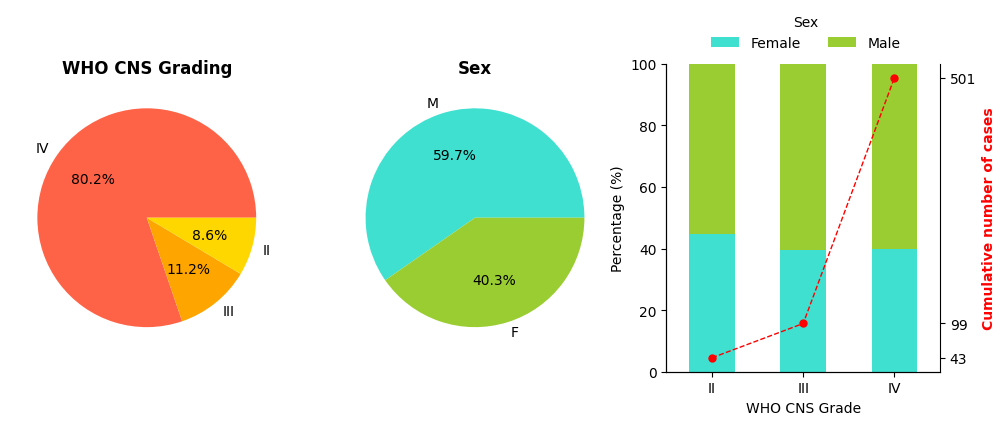

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

# Grade distribution
meta_data["WHO CNS Grade"].value_counts().plot.pie(
                                                    labels=["IV", "III", "II"], ax=ax[0],
                                                    autopct='%1.1f%%',
                                                    colors=['tomato', 'orange', 'gold']
                                                )
ax[0].set_title("WHO CNS Grading", fontweight='bold')
ax[0].set_ylabel("")

# Sex
meta_data["Sex"].value_counts().plot.pie(
                                            labels=["M", "F"], ax=ax[1],
                                            autopct='%1.1f%%',
                                            colors=['turquoise', 'yellowgreen']
                                        )
ax[1].set_title("Sex", fontweight='bold')
ax[1].set_ylabel("")

# Joint
dt = np.array(meta_data.groupby(["WHO CNS Grade", "Sex"])["Sex"].count().unstack())
dt = pd.DataFrame(
    [dt[i]/dt[i].sum() for i in range(dt.shape[0])],
    columns=["Female", "Male"],
    index=["II", "III", "IV"]
)*100
dt.plot.bar(
    stacked=True,
    ax=ax[2],
    color=['turquoise', 'yellowgreen']
)
ax[2].set_xticklabels(["II", "III", "IV"], rotation=0)
ax[2].spines[["top","right"]].set_visible(False)
ax[2].legend(frameon=False, ncols=2, title="Sex", fancybox=False, bbox_to_anchor=(0.5, .8, 0.4, 0.4))
ax[2].set_ylabel("Percentage (%)")
ax[2].set_xlabel("WHO CNS Grade")
ax[2].set_ylim([0,100])
cum = ax[2].twinx()
cum.spines[["top"]].set_visible(False)
yy = np.cumsum(np.array(meta_data["WHO CNS Grade"].value_counts())[::-1])
cum.plot(yy, "--o", color="red", linewidth=1, markersize=5)
cum.set_ylabel("Cumulative number of cases", color='red', fontweight="bold")
cum.set_yticks(yy)

plt.savefig("Sex-grade.pdf", dpi=200, format='pdf', bbox_inches='tight')

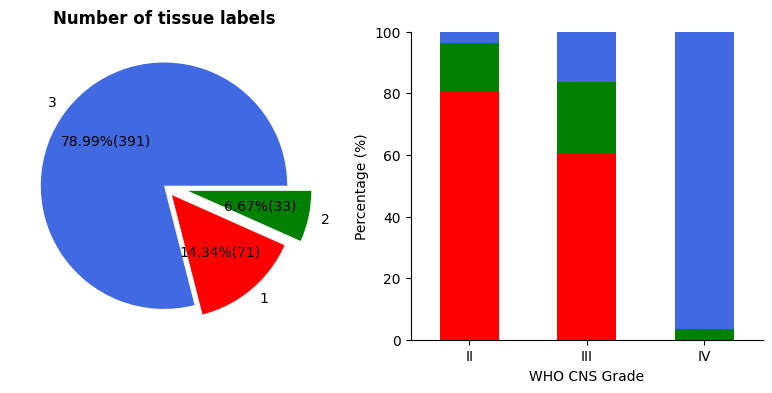

In [24]:
fig, (ax3,ax) = plt.subplots(1,2,figsize=(10,4))
# Labels
dt = np.nan_to_num(np.array(meta_data_v3.groupby(["WHO CNS Grade", "# Labels"])["# Labels"].count().unstack()))
dt = pd.DataFrame(
    [dt[i]/dt[i].sum() for i in range(dt.shape[0])],
    columns=["1", "2", "3"],
    index=["II", "III", "IV"]
)*100
dt.plot.bar(
    stacked=True,
    ax=ax,
    color=['red', 'green', 'royalblue'],
    legend=False
)
ax.set_xticklabels(["II", "III", "IV"], rotation=0)
ax.spines[["top","right"]].set_visible(False)
ax.set_ylabel("Percentage (%)")
ax.set_xlabel("WHO CNS Grade")
ax.set_ylim([0,100])

# Labels
dt = meta_data_v3["# Labels"].value_counts()
dt.plot.pie(
            ax=ax3,
            labels=[3,1,2],
            autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*dt.sum()),
            colors=["royalblue","red","green"],
            explode=[0, 0.1, 0.2],
            #startangle=10
        )
ax3.set_title("Number of tissue labels", fontweight='bold')
ax3.set_ylabel("")

plt.savefig("Labels.pdf", dpi=200, format='pdf', bbox_inches='tight')

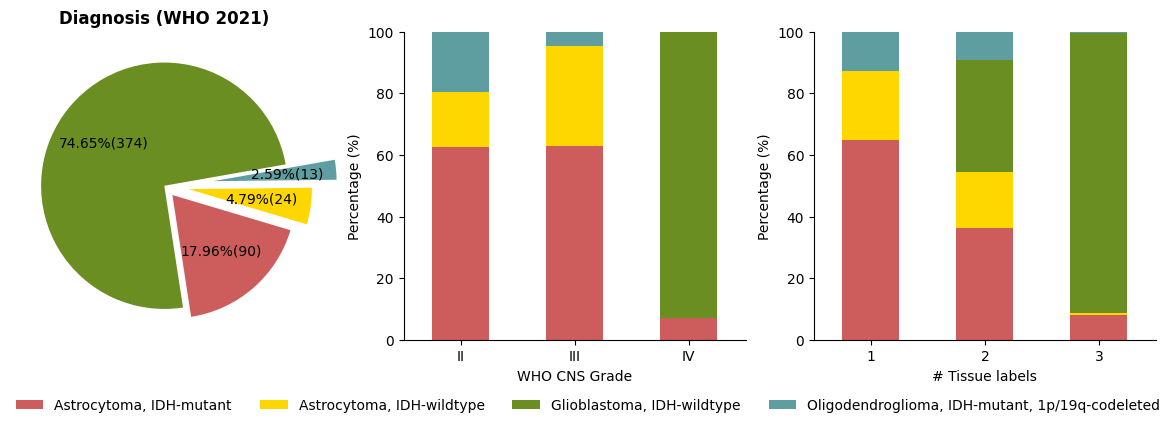

In [23]:
fig, (ax3,ax2,ax1) = plt.subplots(1,3,figsize=(15,4))
# Types
color_types = ["indianred", "gold", "olivedrab", "cadetblue"]
dt = meta_data_v3.groupby(["# Labels", "Final pathologic diagnosis (WHO 2021)"])["# Labels"].count().unstack()
dt_a = np.nan_to_num(np.array(dt))
dt = pd.DataFrame(
    [dt_a[i]/dt_a[i].sum() for i in range(dt_a.shape[0])],
    columns=dt.columns,
    index=[1,2,3]
)*100
dt.plot.bar(
    stacked=True,
    ax=ax1,
    color=color_types
)
ax1.set_xticklabels([1,2,3], rotation=0)
ax1.legend(frameon=False, fancybox=False, bbox_to_anchor=(0.65, -0.55, 0.4, 0.4), ncols=4)
ax1.set_ylabel("Percentage (%)")
ax1.set_xlabel("# Tissue labels")
ax1.set_ylim([0,100])
ax1.spines[["top","right"]].set_visible(False)

# Grade and type
dt = meta_data_v3.groupby(["WHO CNS Grade", "Final pathologic diagnosis (WHO 2021)"])["WHO CNS Grade"].count().unstack()
dt_a = np.nan_to_num(np.array(dt))
dt = pd.DataFrame(
    [dt_a[i]/dt_a[i].sum() for i in range(dt_a.shape[0])],
    columns=dt.columns,
    index=[1,2,3]
)*100
dt.plot.bar(
    stacked=True,
    ax=ax2,
    color=color_types,
    legend=False
)
ax2.set_xticklabels([1,2,3], rotation=0)
ax2.set_ylabel("Percentage (%)")
ax2.set_xlabel("WHO CNS Grade")
ax2.set_ylim([0,100])
ax2.spines[["top","right"]].set_visible(False)
ax2.set_xticklabels(["II", "III", "IV"], rotation=0)

dt = meta_data_v3["Final pathologic diagnosis (WHO 2021)"].value_counts()
color_types = [ "olivedrab", "indianred", "gold","cadetblue"]
dt.plot.pie(
            ax=ax3,
            labels=None,
            autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*dt.sum()),
            colors=color_types,
            explode=[0, 0.1, 0.2, 0.4],
            startangle=10
        )
ax3.set_title("Diagnosis (WHO 2021)", fontweight='bold')
ax3.set_ylabel("")

plt.savefig("Diagnosis_WHO-2021.pdf", bbox_inches='tight', dpi=200, format='pdf')

# Heatmaps

In [60]:
k = 0
for i,id in tqdm(enumerate(meta_data["ID"])):
    ID = id[:9]+"-0"+id[10:]
    try:
        lesion = nib.load(
                f"./UCSF-PDGM-v3/{ID}_nifti/{ID}_tumor_segmentation.nii.gz"
            )
        if i==0:
            lesions = np.where(lesion.get_fdata()>=1,1,0)
            lesions_1 = np.where(lesion.get_fdata()==1,1,0)
            lesions_2 = np.where(lesion.get_fdata()==2,2,0)
            lesions_3 = np.where(lesion.get_fdata()==3,3,0)
            lesions_4 = np.where(lesion.get_fdata()==4,4,0)
        else:
            lesions += np.where(lesion.get_fdata()>=1,1,0)
            lesions_1 += np.where(lesion.get_fdata()==1,1,0)
            lesions_2 += np.where(lesion.get_fdata()==2,2,0)
            lesions_3 += np.where(lesion.get_fdata()==3,3,0)
            lesions_4 += np.where(lesion.get_fdata()==4,4,0)
        k += 1
    except:
        print(f"Segmentations for {ID} not found")
affine, header = lesion.affine, lesion.header
nan_lesions = np.where(lesions==0, np.nan, lesions)
nan_lesions_1 = np.where(lesions_1==0, np.nan, lesions_1)
nan_lesions_2 = np.where(lesions_2==0, np.nan, lesions_2)
nan_lesions_3 = np.where(lesions_3==0, np.nan, lesions_3)
nan_lesions_4 = np.where(lesions_4==0, np.nan, lesions_4)

# 1 --> Tumor core
# 2 --> Edema
# 3 --> NA
# 4 --> Enhancing

120it [01:01,  1.71it/s]

Segmentations for UCSF-PDGM-0138 not found


156it [01:21,  1.41it/s]

Segmentations for UCSF-PDGM-0175 not found


161it [01:23,  2.54it/s]

Segmentations for UCSF-PDGM-0181 not found


244it [02:05,  1.56it/s]

Segmentations for UCSF-PDGM-0278 not found


255it [02:10,  2.68it/s]

Segmentations for UCSF-PDGM-0289 not found


276it [02:21,  1.81it/s]

Segmentations for UCSF-PDGM-0315 not found


501it [04:20,  1.93it/s]


In [81]:
plotting.plot_anat(
    nib.Nifti1Image(nan_lesions, affine, header),
    output_file="Heatmap-all.pdf",
    display_mode="mosaic",
    cmap='hot',
    colorbar=True,
    annotate=False    
)
plotting.plot_anat(
    nib.Nifti1Image(nan_lesions_1, affine, header),
    output_file="Heatmap-necrotic.pdf",
    display_mode="mosaic",
    cmap='hot',
    colorbar=True,
    annotate=False    
)
plotting.plot_anat(
    nib.Nifti1Image(nan_lesions_2, affine, header),
    output_file="Heatmap-edema.pdf",
    display_mode="mosaic",
    cmap='hot',
    colorbar=True,
    annotate=False    
)
plotting.plot_anat(
    nib.Nifti1Image(nan_lesions_3, affine, header),
    output_file="Heatmap-none.pdf",
    display_mode="mosaic",
    cmap='hot',
    colorbar=True,
    annotate=False   
)
plotting.plot_anat(
    nib.Nifti1Image(nan_lesions_4, affine, header),
    output_file="Heatmap-enhancing.pdf",
    display_mode="mosaic",
    cmap='hot',
    colorbar=True,
    annotate=False 
)

' plotting.plot_anat(\n    nib.Nifti1Image(nan_lesions_3, affine, header),\n    output_file="Heatmap-none.pdf",\n    display_mode="mosaic",\n    cmap=\'hot\',\n    colorbar=True,\n    annotate=False   \n)\nplotting.plot_anat(\n    nib.Nifti1Image(nan_lesions_4, affine, header),\n    output_file="Heatmap-enhancing.pdf",\n    display_mode="mosaic",\n    cmap=\'hot\',\n    colorbar=True,\n    annotate=False \n) '